# SOM for CF

SOM code from following repo:

https://github.com/giannisnik/som

https://github.com/Dotori-HJ/SelfOrganizingMap-SOM


In [1]:
import torch
import torch.nn as nn
from torchvision.utils import save_image

import os
import time
import torch
import argparse
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torchvision.datasets as datasets
import torchvision.transforms as transforms
from torch.utils.data.dataloader import DataLoader
from torch.utils.data import DataLoader, TensorDataset, SequentialSampler

from sklearn.model_selection import train_test_split

import torch.nn as nn
from torch.autograd import Variable

Define SOM class

In [2]:
"""
Much of the code is modified from:
- https://codesachin.wordpress.com/2015/11/28/self-organizing-maps-with-googles-tensorflow/
"""

class SOM(nn.Module):
    """
    2-D Self-Organizing Map with Gaussian Neighbourhood function
    and linearly decreasing learning rate.
    """
    def __init__(self, m, n, dim, niter, alpha=None, sigma=None):
        super(SOM, self).__init__()
        self.m = m
        self.n = n
        self.dim = dim
        self.niter = niter
        if alpha is None:
            self.alpha = 0.3
        else:
            self.alpha = float(alpha)
        if sigma is None:
            self.sigma = max(m, n) / 2.0
        else:
            self.sigma = float(sigma)

        self.weights = torch.randn(m*n, dim)
        self.locations = torch.LongTensor(np.array(list(self.neuron_locations())))
        self.pdist = nn.PairwiseDistance(p=2)

    def get_weights(self):
        return self.weights

    def get_locations(self):
        return self.locations

    def neuron_locations(self):
        for i in range(self.m):
            for j in range(self.n):
                yield np.array([i, j])

    def map_vects(self, input_vects):
        to_return = []
        for vect in input_vects:
            min_index = min([i for i in range(len(self.weights))],
                            key=lambda x: np.linalg.norm(vect-self.weights[x]))
            to_return.append(self.locations[min_index])

        return to_return

    def forward(self, x, it):
        dists = self.pdist(torch.stack([x for i in range(self.m*self.n)]), self.weights)
        _, bmu_index = torch.min(dists, 0)
        bmu_loc = self.locations[bmu_index,:]
        bmu_loc = bmu_loc.squeeze()
        
        learning_rate_op = 1.0 - it/self.niter
        alpha_op = self.alpha * learning_rate_op
        sigma_op = self.sigma * learning_rate_op

        bmu_distance_squares = torch.sum(torch.pow(self.locations.float() - torch.stack([bmu_loc for i in range(self.m*self.n)]).float(), 2), 1)
        
        neighbourhood_func = torch.exp(torch.neg(torch.div(bmu_distance_squares, sigma_op**2)))
        
        learning_rate_op = alpha_op * neighbourhood_func

        learning_rate_multiplier = torch.stack([learning_rate_op[i:i+1].repeat(self.dim) for i in range(self.m*self.n)])
        delta = torch.mul(learning_rate_multiplier, (torch.stack([x for i in range(self.m*self.n)]) - self.weights))                                         
        new_weights = torch.add(self.weights, delta)
        self.weights = new_weights

Set up directory paths for data, results, models; set up parameters and hyperparameters for the network

In [14]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

# Hyper parameters
DATA_PATH = './data/data_train.csv'
RES_DIR = './results/som/'
MODEL_DIR = './models/som/'


batch_size = 64
total_epoch = 1000
row = 10000
col = 1000
train = True
load = False
n_iter = 100

Get data and set up dataloader (code from official baseline)

In [4]:
#official baseline code

data_pd = pd.read_csv(DATA_PATH)

# Split the dataset into train and test

train_size = 0.9

train_pd, test_pd = train_test_split(data_pd, train_size=train_size, random_state=42)

def extract_users_items_predictions(data_pd):
    users, movies = \
        [np.squeeze(arr) for arr in np.split(data_pd.Id.str.extract('r(\d+)_c(\d+)').values.astype(int) - 1, 2, axis=-1)]
    predictions = data_pd.Prediction.values
    return users, movies, predictions

train_users, train_movies, train_predictions = extract_users_items_predictions(train_pd)

# also create full matrix of observed values
data = np.full((row, col), np.mean(train_pd.Prediction.values))
mask = np.zeros((row, col)) # 0 -> unobserved value, 1->observed value

for user, movie, pred in zip(train_users, train_movies, train_predictions):
    data[user - 1][movie - 1] = pred
    mask[user - 1][movie - 1] = 1


#get test data

test_users, test_movies, test_predictions = extract_users_items_predictions(test_pd)

In [5]:
#official baseline code
# Build Dataloaders
data_torch = torch.tensor(data, device=device).float()
mask_torch = torch.tensor(mask, device=device)

dataloader = DataLoader(
    TensorDataset(data_torch, mask_torch),
    batch_size=batch_size)

In [9]:
print(type(data_torch))

<class 'torch.Tensor'>


Build model or load it

In [6]:
print('Building Model...')

m=10
n=10

som = SOM(m=m, n=n, dim=1000, niter=n_iter, alpha=None, sigma=None)

if (load and os.path.exists('%s/som.pth' % MODEL_DIR)):
	som.load_state_dict(torch.load('%s/som.pth' % MODEL_DIR))
	print('Model Loaded!')
else:
	print('Create Model!')

som = som.to(device)

Building Model...
Create Model!


Training loop 

In [18]:
som = som.cuda()

In [21]:
for iter_no in range(n_iter):
    print("Iter " + str(iter_no))
    #Train with each vector one by one
    for i in range(len(data)):
        #print("Iter " + str(i))
        data_tens = torch.tensor(data[i])
        som(data_tens, iter_no)

    if iter_no % 5 == 0:
        # save
        print("Saving checkpoint")
        torch.save(som.state_dict(), '%s/som.pth' % MODEL_DIR)


Iter 0
Saving checkpoint
Iter 1
Iter 2
Iter 3
Iter 4
Iter 5
Saving checkpoint
Iter 6
Iter 7
Iter 8
Iter 9
Iter 10
Saving checkpoint
Iter 11
Iter 12
Iter 13
Iter 14
Iter 15
Saving checkpoint
Iter 16
Iter 17
Iter 18
Iter 19
Iter 20
Saving checkpoint
Iter 21
Iter 22
Iter 23
Iter 24
Iter 25
Saving checkpoint
Iter 26
Iter 27
Iter 28
Iter 29
Iter 30
Saving checkpoint
Iter 31
Iter 32
Iter 33
Iter 34
Iter 35
Saving checkpoint
Iter 36
Iter 37
Iter 38
Iter 39
Iter 40
Saving checkpoint
Iter 41
Iter 42
Iter 43
Iter 44
Iter 45
Saving checkpoint
Iter 46
Iter 47
Iter 48
Iter 49
Iter 50
Saving checkpoint
Iter 51
Iter 52
Iter 53
Iter 54
Iter 55
Saving checkpoint
Iter 56
Iter 57
Iter 58
Iter 59
Iter 60
Saving checkpoint
Iter 61
Iter 62
Iter 63
Iter 64
Iter 65
Saving checkpoint
Iter 66
Iter 67
Iter 68
Iter 69
Iter 70
Saving checkpoint
Iter 71
Iter 72
Iter 73
Iter 74
Iter 75
Saving checkpoint
Iter 76
Iter 77
Iter 78
Iter 79
Iter 80
Saving checkpoint
Iter 81
Iter 82
Iter 83
Iter 84
Iter 85
Saving checkpoin

TypeError: Invalid shape (10, 10, 1000) for image data

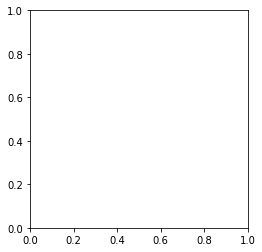

In [22]:
#Store a centroid grid for easy retrieval later on
centroid_grid = [[] for i in range(m)]
weights = som.get_weights()
locations = som.get_locations()
for i, loc in enumerate(locations):
    centroid_grid[loc[0]].append(weights[i].numpy())
 
#Get output grid
image_grid = centroid_grid

#Map colours to their closest neurons
mapped = som.map_vects(torch.Tensor(data))

#Plot
label_groups = ['1','2','3','4','5','6','7','8','9','10']

plt.imshow(image_grid)
plt.title('SOM')
for i, m in enumerate(mapped):
    plt.text(m[1], m[0], label_groups[i], ha='center', va='center',
             bbox=dict(facecolor='white', alpha=0.5, lw=0))
plt.show()

Save plots and model

In [ ]:

torch.save(som.state_dict(), '%s/som.pth' % MODEL_DIR)